## ECS 171 HW 1
There are 398 cars, 9 features in the dataset. According to the observation, all the missing values are represented by '?'. After dropping all the rows with missing values, there are 392 samples. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from numpy.linalg import pinv
from numpy.linalg import inv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the data into a DataFrame
names = ['mpg','cylinders','displacement','horsepower',
         'weight','acceleration','model_year','origin','car_name']
mpg = pd.read_csv('G:/ecs171/auto-mpg.data', header = None, 
                  sep = '\s+', names = names, na_values = '?')
mpg = mpg.dropna()

### P1. Threshold for each category

In [3]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [4]:
mpg['mpg'].describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

According to the percentile of the 'mpg' column, I divide all the cars into four categories using the threshold of 9, 17, 22.75, and 29. 

There are 99 samples in the low category, 97 samples in the median category, 101 samples in the high category and 95 samples in the very high category.  

In [5]:
mpg.loc[mpg['mpg'] <= 17, 'category'] = 'low'
mpg.loc[(mpg['mpg'] > 17) & (mpg['mpg'] <= 22.75), 'category'] = 'median'
mpg.loc[(mpg['mpg'] > 22.75) & (mpg['mpg'] <= 29), 'category'] = 'high'
mpg.loc[mpg['mpg'] > 29, 'category'] = 'very high'

mpg['category'].value_counts()

high         101
low           99
median        97
very high     95
Name: category, dtype: int64

### P2. 2D scatterplot matrix

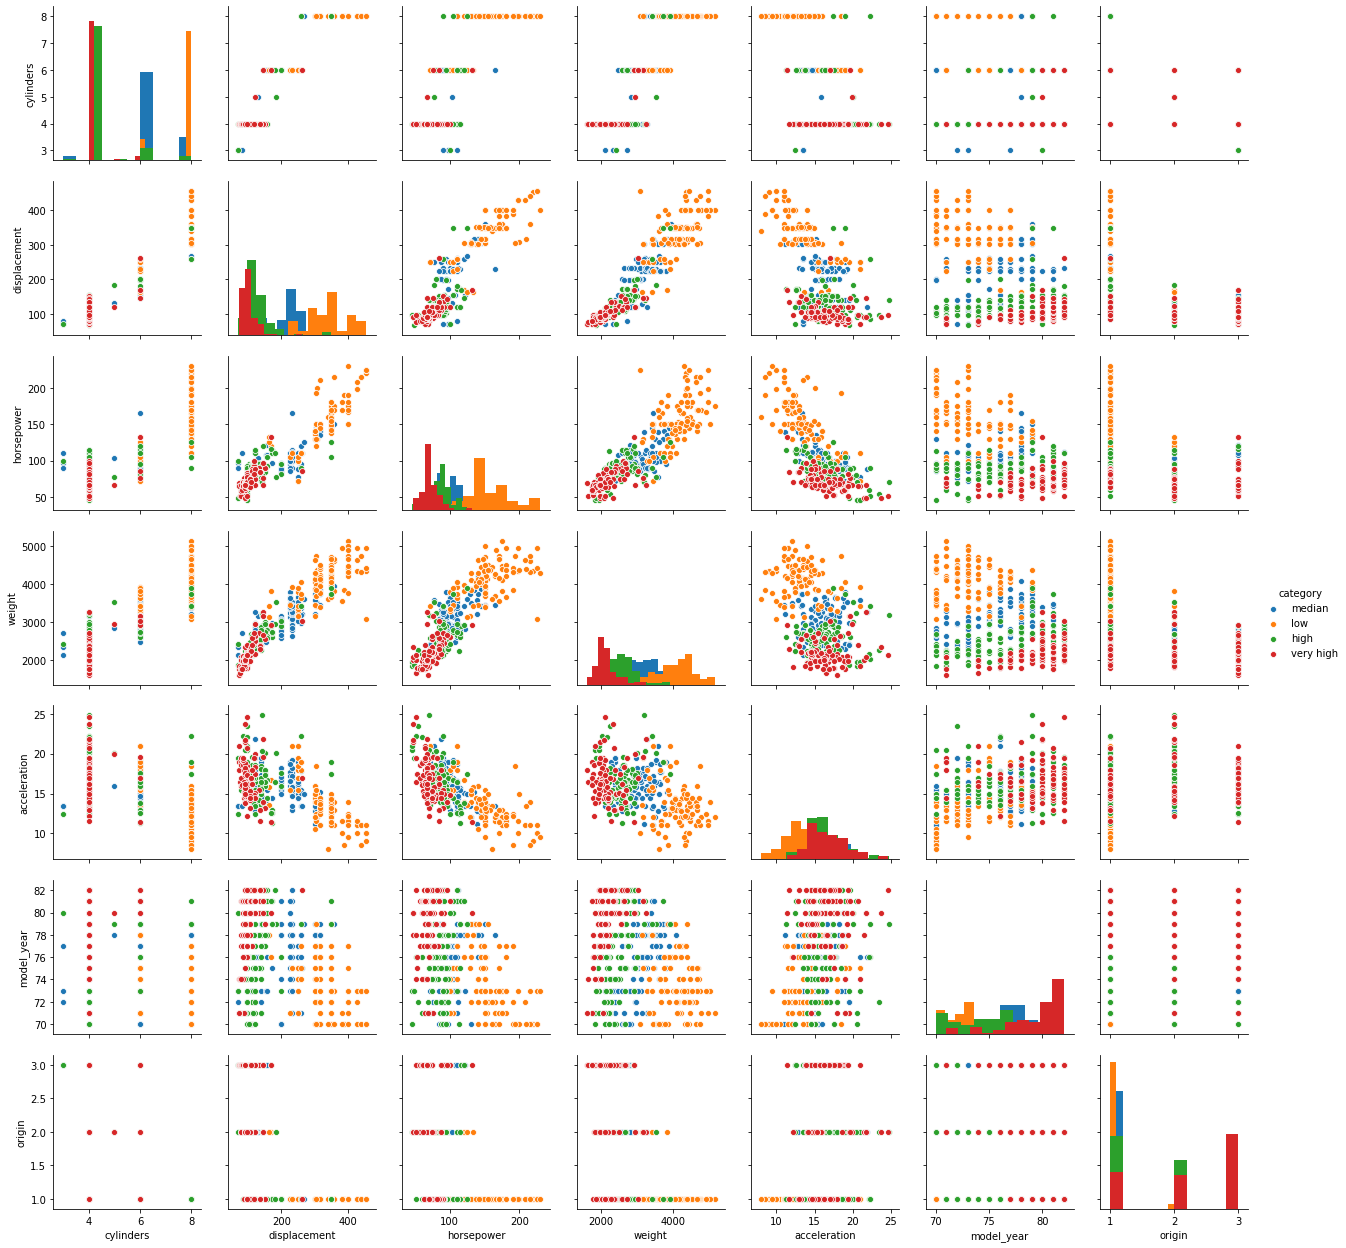

In [6]:
sns.pairplot(mpg.iloc[:,1:], hue = 'category', diag_kind = 'hist',
             plot_kws = {'alpha':1})

From all the pair-wise plots above, the horsepower-displacement and acceleration-displacement combinations are more informative. However, it is still difficult to disdinguish the 'very high' category from the 'high' category. 

### P3. Linear Regression solver

Use the OLS estimator: 

$W = (X^T X)^{-1} X^T Y$

In [34]:
def ols(variable, y, degree, test = None, test_y = None):
    v = np.array(variable).reshape(variable.shape[0], variable.shape[1])
    y = np.array(y).reshape(y.shape[0],1)
    x = np.ones(y.shape[0]).reshape(y.shape[0],1)
    
    if test is not None:
        t = np.array(test)
        test_x = np.ones(test.shape[0]).reshape(test.shape[0],1)
        
    if test_y is not None:
        test_y = np.array(test_y).reshape(test_y.shape[0],1)
        
    # create polynomial design matrix
    for i in range(degree):
        x = np.append(x, v**(i+1), axis = 1)  
        if test is not None:
            test_x = np.append(test_x, t**(i+1), axis = 1)
    
    # linear regression model
    w = inv(np.dot(x.T, x)).dot(x.T).dot(y)
    predict = x.dot(w)
    mse = ((predict -y)**2).sum() / (x.shape[0] - x.shape[1])
    result = {'w':w, 'predict':predict, 'mse':mse}
    
    # for testing dataset
    if test is not None:
        predict_test = test_x.dot(w)
        result['predict_test'] = predict_test
    if test_y is not None:
        mse_test = ((predict_test - test_y)**2).sum() / (test_x.shape[0] - test_x.shape[1])
        result['mse_test'] = mse_test
    
    return result

### P4. Regression for 0th to 3rd order polynomial on a single variable

In [8]:
# shuffle the data
np.random.seed(128)
s = np.random.permutation(mpg.index)
mpg_s = mpg.loc[s]

In [9]:
# 292 samples for training
training = mpg_s.iloc[0:292]

In [10]:
# 100 samples for testint
testing = mpg_s.iloc[292:]

In [11]:
training['category'].value_counts()

high         74
low          74
median       72
very high    72
Name: category, dtype: int64

In [12]:
testing['category'].value_counts()

high         27
median       25
low          25
very high    23
Name: category, dtype: int64

The mpg dataset was shuffled first, then spilted into training and testing set. It is shown that the numbers of 4 categories were nearly in balance for both training set and testing set.

In [13]:
def fit_func(x, degree, w):
    y = 0
    for i in range(degree + 1):
        y += w[i] * (x**i)  
    return y

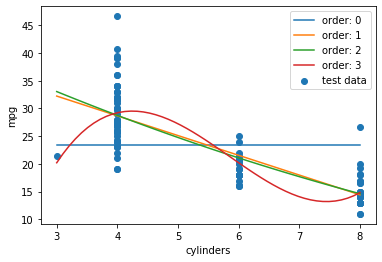

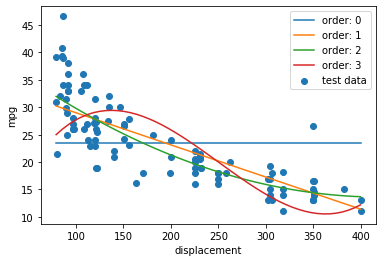

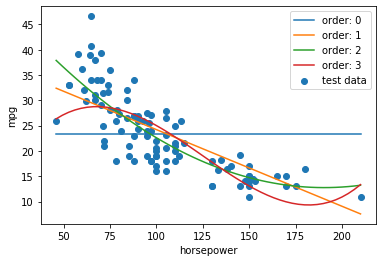

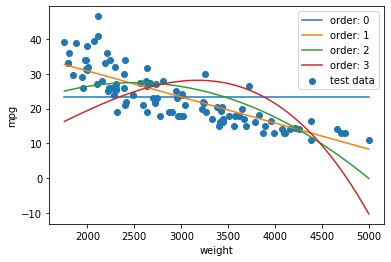

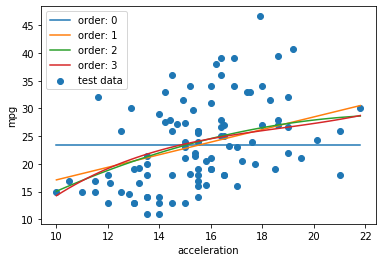

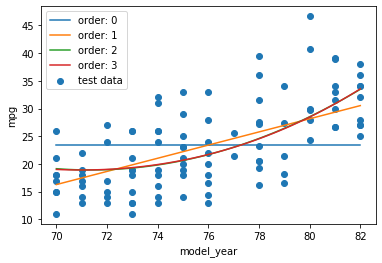

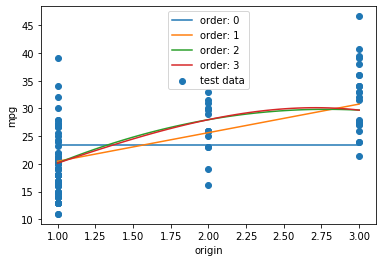

In [14]:
result_train = {}
result_test = {}
   
for i in range(7):
    v1 = '%s.train' % mpg.columns[i+1]
    v2 = '%s.test' % mpg.columns[i+1]
    result_train[v1] = []
    result_test[v2] = []
    # plot
    plt.scatter(testing.iloc[:,(i+1):(i+2)], testing.iloc[:,0], label = 'test data')
    plt.xlabel(mpg.columns[i+1])
    plt.ylabel('mpg')
    for degree in range(4): 
        l = ols(training.iloc[:,(i+1):(i+2)], training.iloc[:,0], degree, testing.iloc[:,(i+1):(i+2)], testing.iloc[:,0])
        result_train[v1].append(l['mse'])
        result_test[v2].append(l['mse_test'])
        t = np.linspace(testing.iloc[:,(i+1)].min(), testing.iloc[:,(i+1)].max())
        plt.plot(t, fit_func(t, degree, l['w']), label = ('order: %s' % degree))
        
    plt.legend(loc='best')
    plt.show()

The table below shows the training and the testing mean squared errors for each variable individually.

In [15]:
result_train = pd.DataFrame(result_train, index = [i for i in range(4)])
result_train.columns.name = 'MSE'
result_train.index.name = 'Order'
result_train

MSE,cylinders.train,displacement.train,horsepower.train,weight.train,acceleration.train,model_year.train,origin.train
Order,,,,,,,
0,61.142396,61.142396,61.142396,61.142396,61.142396,61.142396,61.142396
1,24.279766,21.926821,24.498390,18.991630,50.592790,42.435062,44.376892
2,24.295610,19.652694,19.351496,36.240878,49.869932,40.114010,43.219054
3,22.313723,33.011813,28.422245,89.433545,49.654606,40.292922,43.369121


In [16]:
result_test = pd.DataFrame(result_test, index = [i for i in range(4)])
result_test.columns.name = 'MSE'
result_test.index.name = 'Order'
result_test

MSE,cylinders.test,displacement.test,horsepower.test,weight.test,acceleration.test,model_year.test,origin.test
Order,,,,,,,
0,60.875925,60.875925,60.875925,60.875925,60.875925,60.875925,60.875925
1,24.233718,20.705830,23.562738,18.569247,49.903174,35.682277,34.359321
2,24.098600,17.930580,19.080846,39.948673,49.462781,36.057379,35.891568
3,22.142975,36.741896,27.496850,99.427521,51.109472,36.431625,36.265439


The plots and MSE table aboves show that the 2nd order performs the best in the test set except for the weight feature. There seem to be a curvilinear shape in the mpg-displacemet, mpg-horsepower pairs. The displacement feature is the most informative feature, mpg comsumption will decrease first and then increase slightly as displacement increases.

###  P5. Regression for 0th to 2nd order on all variables

The solver before also holds for the regression on all 7 independent variables, so I use the solver directly.

In [35]:
result = {'train':[], 'test':[]}

for degree in range(3):    
    #result[degree] = []
   # l = ols(training.iloc[:,1:8], training.iloc[:,0], degree, testing.iloc[:,1:8], testing.iloc[:,0])
    l = ols(mpg.iloc[:,1:8], mpg.iloc[:,0], degree)
    print(l['w'])
    #result['train'].append(l['mse'])
   # result['test'].append(l['mse_test'])

#result = pd.DataFrame(result, index = [('%sth order'% i) for i in range(3)])
#result.index.name = 'degree'
#result.columns.name = 'MSE'
#result


[[23.44591837]]
[[-1.72184346e+01]
 [-4.93376319e-01]
 [ 1.98956437e-02]
 [-1.69511442e-02]
 [-6.47404340e-03]
 [ 8.05758383e-02]
 [ 7.50772678e-01]
 [ 1.42614050e+00]]
[[ 4.04830803e+02]
 [ 9.60305244e-01]
 [-2.55862879e-02]
 [-1.54464703e-01]
 [-1.32163017e-02]
 [-1.67726744e+00]
 [-9.56243118e+00]
 [ 2.53380101e+00]
 [-4.65452519e-02]
 [ 3.71399252e-05]
 [ 3.44839881e-04]
 [ 1.52248376e-06]
 [ 4.51883582e-02]
 [ 6.80095012e-02]
 [-4.76169552e-01]]


The table above shows the training and the testing mean squared error.

### P6. Logistic regression

In [18]:
x = training.iloc[:,1:8]
y = training['category']

lr = LogisticRegression(penalty = 'none', solver = 'sag', multi_class = 'multinomial', 
                        max_iter = 6000).fit(x,y)

precision = TP / (TP + FN)

Function in sklearn was used to do the computation. Precision was computed for each category.

In [19]:
y_predict = lr.predict(x)
p_train = precision_score(y, y_predict, labels = ['low', 'median', 'high', 'very high'], average = None)

In [20]:
x_test = testing.iloc[:,1:8]
y_test = testing['category']

test_predict = lr.predict(x_test)
p_test = precision_score(y_test, test_predict, labels = ['low', 'median', 'high', 'very high'], average = None)

In [21]:
# precision for each variable
precision = pd.DataFrame(p_train, index = ['low', 'median', 'high', 'very high'], columns = ['train'])
precision['test'] = p_test
precision

,train,test
low,0.888889,0.916667
median,0.730159,0.750000
high,0.625000,0.714286
very high,0.766234,0.833333


The table above shows the training/testing classfication precision for each category.

### P7. Logistic regression with min-max normalization

In [22]:
scaler = MinMaxScaler()
scaler.fit(x)
x_minmax = scaler.transform(x)
x_test_minmax = scaler.transform(x_test)

In [23]:
lr_minmax = LogisticRegression(penalty = 'none', solver = 'sag', multi_class = 'multinomial', max_iter = 400).fit(x_minmax,y)

In [24]:
# precision for each variable
y_predict2= lr_minmax.predict(x_minmax)
p_train2 = precision_score(y, y_predict2, labels = ['low', 'median', 'high', 'very high'], average = None)

test_predict2 = lr_minmax.predict(x_test_minmax)
p_test2 = precision_score(y_test, test_predict2, labels = ['low', 'median', 'high', 'very high'], average = None)

precision2 = pd.DataFrame(p_train2, index = ['low', 'median', 'high', 'very high'], columns = ['train'])
precision2['test'] = p_test2
precision2

,train,test
low,0.917808,0.954545
median,0.769231,0.714286
high,0.683544,0.782609
very high,0.840000,0.814815


The table above shows the training/testing classfication precision for each category.

After apply min-max normalization to the dataset, the logistic regression solver converges within much less iteration times, while the precision dose not change too much. Originally it takes over 5500 iterations to converge, but now it can converge within 400 interation. 

### P8. Prediction for a specific sample

In [25]:
x0 = np.array([4, 400, 150, 3500, 8, 81, 1]).reshape(1,-1)

In [26]:
# second-order multi-variate polynomial regression
l = ols(mpg.iloc[:,1:8], mpg.iloc[:,0], 2, x0)
l['predict_test']

array([[20.84423678]])

In [27]:
# logistic regression
l = LogisticRegression(penalty = 'l2', solver = 'sag', multi_class = 'multinomial', max_iter = 5000).fit(mpg.iloc[:,1:8],mpg['category'])
l.predict(x0)

array(['low'], dtype=object)

In [28]:
scaler2 = MinMaxScaler()
scaler2.fit(mpg.iloc[:,1:8])
x_minmax = scaler2.transform(mpg.iloc[:,1:8])
x0_minmax = scaler2.transform(x0)

l2 = LogisticRegression(penalty = 'l2', solver = 'sag', multi_class = 'multinomial').fit(x_minmax,mpg['category'])
l2.predict(x0_minmax)

array(['median'], dtype=object)

The prediction of second-order multi-variate polynomial regression is 20.84423678. The prediction of logistic regression is 'low'. The prediction of logistic regression with min-max normalization is 'median'. 